In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

Simple logistic regression

In [20]:
data = pd.read_csv('data/ML_DATA_LEV.csv')
data.dropna(inplace= True)

true_label = data.BINARY_PHENOTYPE

features = ['d_volume', 'd_hydropathy_KD', 'd_hydropathy_WW',
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 'psi', 'residue_sasa', 
       'n_hbond_acceptors', 'n_hbond_donors', 'SASA', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug'] # 'B', 'C', 'E', 'G', 'H', 'T',

features = data[features]
features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
features.drop('secondary_structure', inplace = True, axis = 1)

true_label
features

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_2772/4250998091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_2772/4250998091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop('secondary_structure', inplace = True, axis = 1)


,d_volume,d_hydropathy_KD,d_hydropathy_WW,d_MW,d_Pi,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,dist_MGB,dist_MGE,dist_drug,secondary_structure_codes
0,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64,14.254302,5.504266,10.310827,0
1,82.5,2.2,-2.18,48.1,2.89,-58.04,-41.61,97.4,1.0,1.0,88.155089,81,18.193078,7.778979,14.095746,0
2,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56,18.193078,7.778979,14.095746,0
3,-3.0,0.0,1.98,1.0,-2.64,-66.66,120.50,43.0,2.0,2.0,40.444768,53,21.565351,18.549803,13.333886,1
4,-25.1,2.7,-0.10,-27.0,0.27,-78.75,123.63,5.4,2.0,0.0,3.978588,-22,38.286533,31.644022,37.267766,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56,18.193078,7.778979,14.095746,0
1731,113.3,-4.1,-0.14,99.1,4.79,-78.41,-153.43,22.3,0.0,0.0,21.149837,56,30.228472,32.992962,27.088620,1
1732,48.4,2.9,-0.92,46.1,-0.90,-77.03,152.43,8.6,0.0,0.0,9.936179,50,9.383464,8.798144,11.185202,1
1733,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56,18.193078,7.778979,14.095746,0


In [21]:
random_seed = 144

X_train,X_test,y_train,y_test=train_test_split(features,true_label,test_size=0.20,random_state = random_seed) 

In [22]:
random_seed = 144

folds = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)

param_grid = [ 
                {   'penalty': ['l2'],
                    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight' : ['balanced', None]
                } 
            ]

gsvc = GridSearchCV(LogisticRegression(random_state=random_seed), param_grid, cv = folds, scoring = 'f1') #, scoring='f1' , scoring = 'recall'

In [23]:
gsvc.fit(X_train,y_train)
gsvc.cv_results_

/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sk

{'mean_fit_time': array([0.0481585 , 0.02079225, 0.00699711, 0.00683658, 0.02559118,
        0.03084841, 0.03491669, 0.01962571, 0.00588031, 0.006759  ,
        0.02461476, 0.02576063, 0.06293957, 0.01976936, 0.00705962,
        0.00940104, 0.03383811, 0.02878511, 0.04219568, 0.02798259,
        0.00821941, 0.00751874, 0.02450018, 0.02601025, 0.0563766 ,
        0.01928263, 0.00895567, 0.00734525, 0.02698078, 0.02590683,
        0.04410067, 0.01871867, 0.00872092, 0.00628181, 0.02468493,
        0.02803578, 0.04470773, 0.01902177, 0.01107757, 0.00716407,
        0.02564728, 0.03069797, 0.04441366, 0.02072206, 0.01056237,
        0.00717311, 0.02421556, 0.02609951, 0.05289218, 0.02408693,
        0.01357954, 0.00732286, 0.02569962, 0.02690165, 0.04516938,
        0.02560575, 0.01090977, 0.00681098, 0.02657189, 0.0265125 ,
        0.05399697, 0.02739372, 0.01465609, 0.00719953, 0.02527902,
        0.02743649, 0.05661945, 0.02021117, 0.01263556, 0.00648718,
        0.03133194, 0.02806478,

In [26]:
df = pd.DataFrame(gsvc.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_penalty', 'param_solver',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [27]:
gsvc.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [28]:
gsvc.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [29]:
logreg =  LogisticRegression(solver='newton-cg', random_state=random_seed, class_weight = 'balanced', C = 0.001, penalty = 'l2') 

In [30]:
logreg.fit(X_train,y_train) 

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [31]:
y_pred=logreg.predict(X_test) 

In [32]:
y_df = pd.DataFrame(y_pred)
y_df.value_counts()

R    273
S     70
Name: count, dtype: int64

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[267,   5],
       [  6,  65]])

Text(0.5, 427.9555555555555, 'Predicted label')

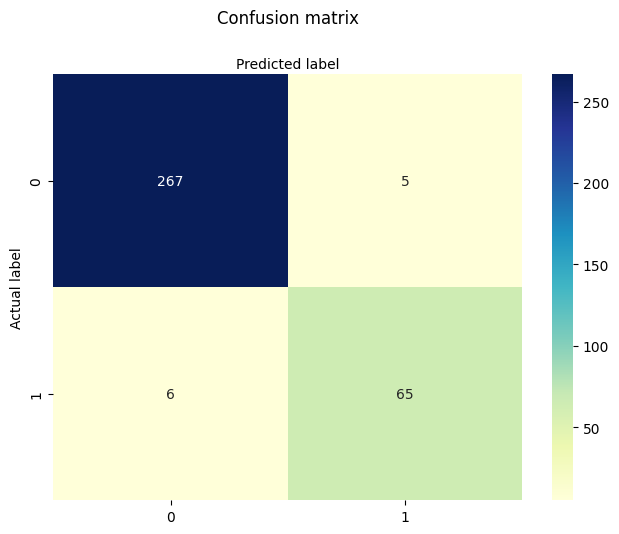

In [34]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [35]:
sensitivity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

0.9154929577464789 0.9816176470588235
